In [1]:
import psycopg2
import pandas as pd
from local_settings import hostname, username, password, port, database

In [2]:
connection = psycopg2.connect(
            host=hostname, user=username, 
            password=password, dbname=database, 
            port=port
        )

In [3]:
sql_query = "SELECT * FROM data_model_county"

df = pd.read_sql_query(sql_query, connection)

connection.close()
print(df.shape)
df.head()

/tmp/ipykernel_46103/780156365.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, connection)


(11950, 17)


,price,area,bath,room,parking,year,property_type,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,county,ranking
0,120375,45,2,3,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
1,119277,45,2,3,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
2,162297,60,2,2,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
3,157815,60,2,2,1,2023,1,1,0,1,0,0,0,1,0,150131,5.00
4,239998,110,3,3,0,2023,1,1,0,0,0,0,0,0,0,150145,3.13


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11950 entries, 0 to 11949
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          11950 non-null  int64  
 1   area           11950 non-null  int64  
 2   bath           11950 non-null  int64  
 3   room           11950 non-null  int64  
 4   parking        11950 non-null  int64  
 5   year           11950 non-null  int64  
 6   property_type  11950 non-null  int64  
 7   near_cc        11950 non-null  int64  
 8   near_school    11950 non-null  int64  
 9   near_parks     11950 non-null  int64  
 10  near_avenue    11950 non-null  int64  
 11  security       11950 non-null  int64  
 12  elevator       11950 non-null  int64  
 13  rest_area      11950 non-null  int64  
 14  pool           11950 non-null  int64  
 15  county         11950 non-null  int64  
 16  ranking        11950 non-null  float64
dtypes: float64(1), int64(16)
memory usage: 1.6 MB


# Deep Learning House Price Prediction

This program predicts the price of a house based off of its features using deep learning

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

2023-09-14 02:35:31.758230: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 02:35:31.800722: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 02:35:31.801827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 02:35:32.593243: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Before to start building up the deep learning model, let's see both plots; the price distitribution and how the variables are co-related with each other

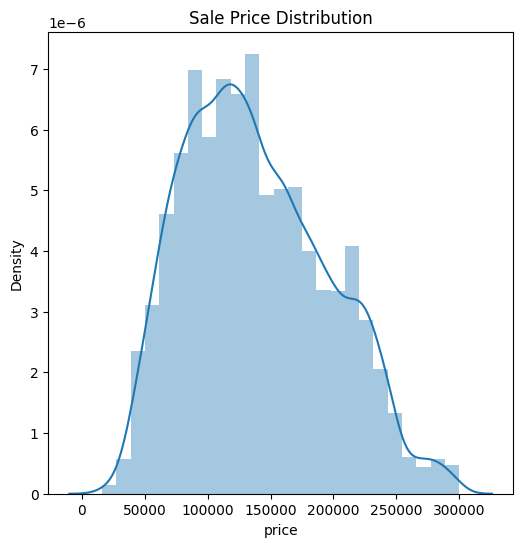

In [6]:
plt.figure(figsize=(6,6))
sns.distplot(df['price'], bins=25)
plt.title("Sale Price Distribution")
plt.show()

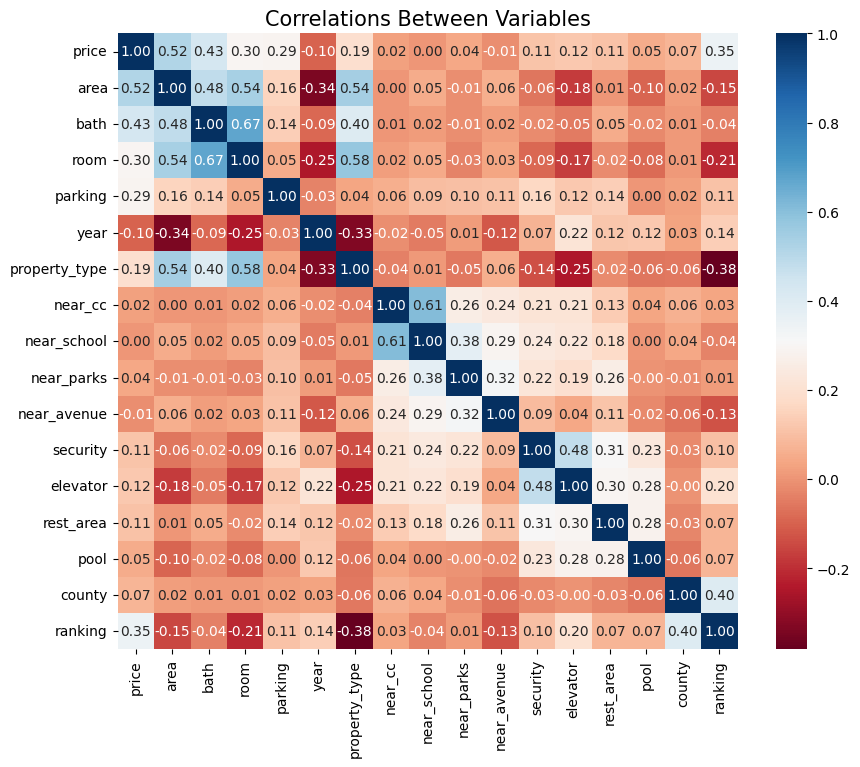

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="RdBu", annot=True, fmt='.2f', annot_kws={'size': 10})
plt.title("Correlations Between Variables", size=15)
plt.show()

## Spliting Data

To move on to building up the model, let's create a matrix (or array) with the data.

In [8]:
data = df.values
data

array([[1.20375e+05, 4.50000e+01, 2.00000e+00, ..., 0.00000e+00,
        1.50131e+05, 5.00000e+00],
       [1.19277e+05, 4.50000e+01, 2.00000e+00, ..., 0.00000e+00,
        1.50131e+05, 5.00000e+00],
       [1.62297e+05, 6.00000e+01, 2.00000e+00, ..., 0.00000e+00,
        1.50131e+05, 5.00000e+00],
       ...,
       [2.90000e+05, 2.66000e+02, 4.00000e+00, ..., 0.00000e+00,
        1.50101e+05, 3.21000e+00],
       [1.39000e+05, 8.30000e+01, 2.00000e+00, ..., 0.00000e+00,
        1.50101e+05, 3.21000e+00],
       [1.00216e+05, 2.18000e+02, 3.00000e+00, ..., 0.00000e+00,
        1.50107e+05, 2.71000e+00]])

Split the data set into independent and dependent data sets, namely, independent parameter are all features but 'price' which is our variable to predict.

In [9]:
# X = data[:,1:]
# Y = data[:,0]
# print(X.shape, Y.shape)

In [10]:
X = df.iloc[:, 1:]
Y = df['price'].values
print(X.shape, Y.shape)

(11950, 16) (11950,)


Because our model has to be independent in relation to the scaled used for each parameter, let's re scale all data.
We use the min-max scaler method from prepocessing which scales the dataset so that all the features lie between 0 and 1 inclusive

In [11]:
scale = StandardScaler()
X_scale = scale.fit_transform(X)
X_scale

array([[-1.08663274, -0.19077468,  0.04045264, ..., -0.30564877,
         0.58368098,  1.15675748],
       [-1.08663274, -0.19077468,  0.04045264, ..., -0.30564877,
         0.58368098,  1.15675748],
       [-0.78146434, -0.19077468, -0.81212072, ..., -0.30564877,
         0.58368098,  1.15675748],
       ...,
       [ 3.40951502,  2.47560829,  0.89302601, ..., -0.30564877,
        -1.40504367, -0.63007453],
       [-0.31353946, -0.19077468, -0.81212072, ..., -0.30564877,
        -1.40504367, -0.63007453],
       [ 2.43297614,  1.14241681,  2.59817275, ..., -0.30564877,
        -1.00729874, -1.12918962]])

Let's split our data into 70% training and 30% (testing (15%) validating (15%))

In [12]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5, random_state=0)
print(X_train.shape, X_val.shape, X_test.shape, Y_test.shape, Y_val.shape, Y_test.shape)

(8365, 16) (1792, 16) (1793, 16) (1793,) (1792,) (1793,)


In [13]:
X_train

array([[ 0.84610046, -0.19077468,  0.04045264, ..., -0.30564877,
        -1.40504367, -0.63007453],
       [-0.5983633 , -0.19077468, -0.81212072, ..., -0.30564877,
         1.44546166, -1.0393489 ],
       [-0.84249802, -0.19077468, -0.81212072, ..., -0.30564877,
        -0.60955381,  1.15675748],
       ...,
       [-0.5983633 , -1.52396617, -0.81212072, ..., -0.30564877,
         1.24658919,  0.64766009],
       [ 0.45955382, -0.19077468, -0.81212072, ..., -0.30564877,
        -1.07358956, -1.93775606],
       [-0.92387626, -1.52396617, -1.66469409, ...,  3.27172914,
        -0.01293642,  1.15675748]])

## Model

Since we goint to use a Neural Network, let's set up the layer and neurons.

In [14]:
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

we can define metric to optimize and the method to do it. Moreover, we add the ***Loss Function*** which measures how well the model did on training, and then tries to improve on it using the optimizer

In [15]:
model.compile(
    optimizer ='adam',
    loss='mean_squared_error',
    metrics=[metrics.mae, metrics.Accuracy()]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 30)                330       
                                                                 
 dense_2 (Dense)             (None, 40)                1240      
                                                                 
 dense_3 (Dense)             (None, 30)                1230      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3291 (12.86 KB)
Trainable params: 3291 (12

With this setting we can train our model

In [16]:
hist = model.fit(
    X_train, Y_train.reshape(-1,1),
    batch_size=32,
    epochs=300,
    validation_data=(X_val, Y_val.reshape(-1,1))
)

Epoch 1/300


262/262 [==============================] - 2s 2ms/step - loss: 20352081920.0000 - mean_absolute_error: 130971.9844 - accuracy: 0.0000e+00 - val_loss: 10231288832.0000 - val_mean_absolute_error: 89073.9453 - val_accuracy: 0.0000e+00
Epoch 2/300
262/262 [==============================] - 0s 1ms/step - loss: 3239851520.0000 - mean_absolute_error: 43827.4375 - accuracy: 0.0000e+00 - val_loss: 2187352832.0000 - val_mean_absolute_error: 36582.6602 - val_accuracy: 0.0000e+00
Epoch 3/300
262/262 [==============================] - 0s 1ms/step - loss: 1966639744.0000 - mean_absolute_error: 34518.5508 - accuracy: 0.0000e+00 - val_loss: 1886126336.0000 - val_mean_absolute_error: 33423.8086 - val_accuracy: 0.0000e+00
Epoch 4/300
262/262 [==============================] - 0s 1ms/step - loss: 1756226816.0000 - mean_absolute_error: 32402.5957 - accuracy: 0.0000e+00 - val_loss: 1719872640.0000 - val_mean_absolute_error: 31883.8711 - val_accuracy: 0.0000e+00
Epoch 5/300
262/262 [========================

In [17]:
model.evaluate(X_test, Y_test.reshape(-1,1))

57/57 [==============================] - 0s 972us/step - loss: 1240541568.0000 - mean_absolute_error: 26964.5391 - accuracy: 0.0000e+00


[1240541568.0, 26964.5390625, 0.0]

In [23]:
prediction = model.predict(X_test)
prediction = prediction.flatten()
prediction

57/57 [==============================] - 0s 786us/step


array([122260.17,  78936.59, 158912.25, ..., 186572.33, 134227.67,
       134029.11], dtype=float32)

In [24]:
Y_test

array([104483,  92000, 163452, ...,  65000, 110000, 129000])

In [29]:
(prediction - Y_test)

array([ 17777.171875, -13063.40625 ,  -4539.75    , ..., 121572.328125,
        24227.671875,   5029.109375])

In [31]:
((Y_test - abs(prediction - Y_test))/Y_test).mean()

0.779613219199678

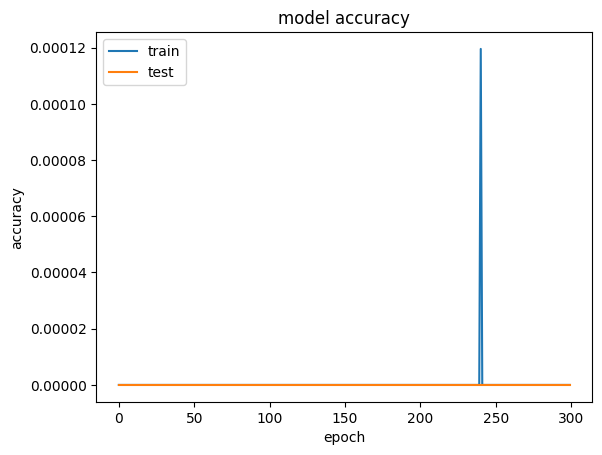

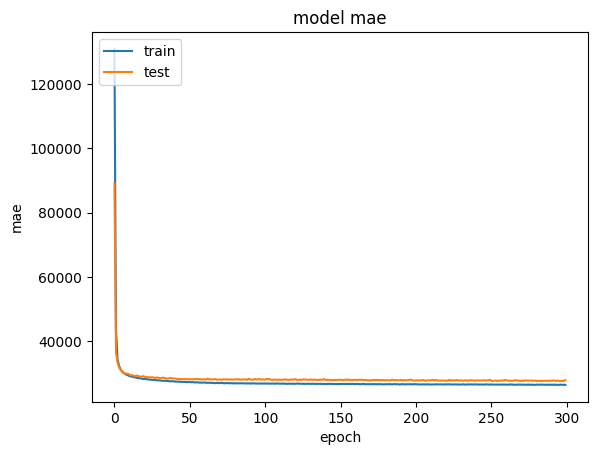

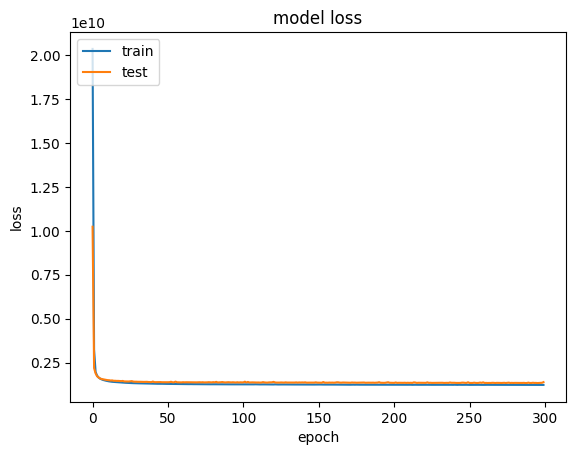

In [20]:
# summarize history for mae
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()